# Thème 4 : Le vélo au service des espaces du quotidien
**Analyse carto :** Concentration points bleu x fréquentation et localisation des principales gares de France  
- Identifier la concentration des besoins en stationnement à moins de 100 mètres des gares de france

> Hypothèse : Un nombre important de cyclistes identifie la gare comme un lieu important à aménager. <br/>
> Le besoin d’adapter les gares au vélo est toujours aussi pressant, notamment dans le cadre des projets de SERM

## Python stuff

In [1]:
import pandas as pd
import geopandas as gpd
from s3_utils import S3Manager
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

_ = plt.style.use("ggplot")

In [2]:
# Chargement des éléments de connexion sur S3
s3_manager = S3Manager()
bucket = "fub-s3"

## 1 - Récupération des données 

In [3]:
# Import des données sources
gdf = s3_manager.load_geojson_from_s3(bucket, "data/DFG/2025/data_geo/données-carto-2025-06-03.geojson")
print(gdf.crs)
gdf.head(2)

✅ Fichier chargé et converti en GeoDataFrame avec succès
EPSG:4326


,uid,cat,uid_reponse,description,geometry
0,dd441ba7-d3a7-490e-8cfe-1d34e4a09311,58,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Route trop étroite et dangereuse,POINT (4.47109 47.1244)
1,63ef8e40-8be8-4362-b9ea-5b38a0347ef3,59,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Maison de santé,POINT (4.48483 47.13117)


In [4]:
url_contour_france = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
contour_france = gpd.read_file(url_contour_france)

In [5]:
gdf = gdf.to_crs(contour_france.crs)
gdf_filtre = gpd.sjoin(gdf, contour_france, predicate="within", how="inner")
gdf_filtre = gdf_filtre.drop(columns=["index_right"])

In [6]:
gares_france = s3_manager.load_geojson_from_s3(bucket, "data/DFG/2025/data_geo/externe/4Aliste-des-gares.geojson")
print(gares_france.shape)
print(gares_france.crs)
gares_france.head(2)

✅ Fichier chargé et converti en GeoDataFrame avec succès
(3884, 18)
EPSG:4326


,code_uic,libelle,fret,voyageurs,code_ligne,rg_troncon,pk,commune,departemen,idreseau,idgaia,x_l93,y_l93,x_wgs84,y_wgs84,c_geo,geo_point_2d,geometry
0,87009696,La Douzillère,N,O,594000,1,244+100,JOUE-LES-TOURS,INDRE-ET-LOIRE,4650,d9dc0092-6667-11e3-89ff-01f464e0362d,522803.9864,6.695782e+06,0.653001,47.338661,"{ ""lon"": 0.6530013866824887, ""lat"": 47.3386614...","{ ""lon"": 0.6530013866824868, ""lat"": 47.3386614...",POINT (0.653 47.33866)
1,87142554,Châtillon-sur-Seine,O,N,839000,1,035+431,SAINTE-COLOMBE-SUR-SEINE,COTE-D'OR,9201,29d3de32-dfbc-11e3-a2ff-01a464e0362d,815990.5833,6.753363e+06,4.551565,47.870404,"{ ""lon"": 4.551565119152175, ""lat"": 47.87040423...","{ ""lon"": 4.551565119152176, ""lat"": 47.87040423...",POINT (4.55157 47.8704)


In [7]:
gares_france = gares_france[['code_uic', 'libelle', 'commune', 'departemen', 'geometry']].copy()
gares_france.head(2)

,code_uic,libelle,commune,departemen,geometry
0,87009696,La Douzillère,JOUE-LES-TOURS,INDRE-ET-LOIRE,POINT (0.653 47.33866)
1,87142554,Châtillon-sur-Seine,SAINTE-COLOMBE-SUR-SEINE,COTE-D'OR,POINT (4.55157 47.8704)


In [8]:
s3_manager.download_from_s3(
    bucket, 
    "data/DFG/2025/data_geo/externe/4.Afrequentation-gares(2).xlsx", 
    "temp/frequentation-gares.xlsx"
)

✅ Fichier téléchargé depuis S3 : temp/frequentation-gares.xlsx


In [9]:
gf = pd.read_excel("temp/frequentation-gares.xlsx")
gf.head(2)

,Nom de la gare,Code UIC,Code postal,Segmentation DRG,Total Voyageurs 2023,Total Voyageurs + Non voyageurs 2023,Total Voyageurs 2022,Total Voyageurs + Non voyageurs 2022,Total Voyageurs 2021,Total Voyageurs + Non voyageurs 2021,...,Total Voyageurs 2019,Total Voyageurs + Non voyageurs 2019,Total Voyageurs 2018,Total Voyageurs + Non voyageurs 2018,Total Voyageurs 2017,Total Voyageurs + Non voyageurs 2017,Total Voyageurs 2016,Total Voyageurs + Non voyageurs 2016,Total Voyageurs 2015,Total Voyageurs + Non voyageurs 2015
0,Acheux - Franleu,87316745,80560,C,0,0,2,2,0,0,...,2,2,235,235,104,104,308,308,898,898
1,Aiguebelette-le-Lac,87741421,73610,C,4394,4394,4046,4046,3658,3658,...,4754,4754,2535,2535,3117,3117,3912,3912,4071,4071


In [10]:
gares_frequentation_prep = gf[
    ['Nom de la gare', 'Code UIC', 'Code postal',
    'Total Voyageurs 2023', 'Total Voyageurs + Non voyageurs 2023']
].copy()
gares_frequentation_prep.head(2)

,Nom de la gare,Code UIC,Code postal,Total Voyageurs 2023,Total Voyageurs + Non voyageurs 2023
0,Acheux - Franleu,87316745,80560,0,0
1,Aiguebelette-le-Lac,87741421,73610,4394,4394


In [11]:
gares_frequentation_prep["taux_voyageurs_2023"] = (
    gares_frequentation_prep["Total Voyageurs 2023"] / gares_frequentation_prep["Total Voyageurs + Non voyageurs 2023"]
).where(gares_frequentation_prep["Total Voyageurs + Non voyageurs 2023"] != 0, 0) * 100

In [12]:
gares_frequentation_prep[
    ['Nom de la gare', 'Code UIC', 'Code postal', 'taux_voyageurs_2023', 
     'Total Voyageurs + Non voyageurs 2023', 'Total Voyageurs 2023']
].sort_values(by=["taux_voyageurs_2023", "Total Voyageurs 2023"], ascending=False).head(3)

,Nom de la gare,Code UIC,Code postal,taux_voyageurs_2023,Total Voyageurs + Non voyageurs 2023,Total Voyageurs 2023
834,Juvisy-sur-Orge,87545244,91260,100.0,35396457,35396457
2318,Magenta,87281873,75010,100.0,35160793,35160793
2065,Haussmann Saint-Lazare,87281899,75009,100.0,34704501,34704501


In [13]:
# Uniformisation des clés de jointures
gares_frequentation_prep["Code UIC"] = gares_frequentation_prep["Code UIC"].astype("int64")
gares_france.code_uic = gares_france.code_uic.astype("int64")

In [14]:
gares_france_f = gares_france.merge(
    gares_frequentation_prep,
    left_on="code_uic",
    right_on="Code UIC",
    how="inner",
    suffixes=("_gares", "_frequentations")
)
gares_france_f.head(2)

,code_uic,libelle,commune,departemen,geometry,Nom de la gare,Code UIC,Code postal,Total Voyageurs 2023,Total Voyageurs + Non voyageurs 2023,taux_voyageurs_2023
0,87009696,La Douzillère,JOUE-LES-TOURS,INDRE-ET-LOIRE,POINT (0.653 47.33866),La Douzillère,87009696,37300,6573,6573,100.0
1,87382218,La Défense,PUTEAUX,HAUTS-DE-SEINE,POINT (2.23847 48.89344),La Défense,87382218,92800,28148302,28148302,100.0


In [15]:
f_gares_france = gares_france_f[[
    'code_uic', 'Nom de la gare', 'commune', 'departemen', 'geometry',
    'Total Voyageurs 2023',
    'Total Voyageurs + Non voyageurs 2023', 'taux_voyageurs_2023'
]].copy()
f_gares_france.rename(columns={"departemen": "departement"}, inplace=True)
f_gares_france.sort_values(by=["taux_voyageurs_2023", "Total Voyageurs 2023"], ascending=False).head(2)

,code_uic,Nom de la gare,commune,departement,geometry,Total Voyageurs 2023,Total Voyageurs + Non voyageurs 2023,taux_voyageurs_2023
142,87545244,Juvisy-sur-Orge,JUVISY-SUR-ORGE,ESSONNE,POINT (2.38358 48.68926),35396457,35396457,100.0
2481,87545244,Juvisy-sur-Orge,JUVISY-SUR-ORGE,ESSONNE,POINT (2.38062 48.68848),35396457,35396457,100.0


## 2 - Identifier la concentration des besoins en stationnement à moins de 100 mètres des gares de france

### 2.1 - Statistique

In [16]:
# Reprojection spatiale
gdf_2154 = gdf_filtre.to_crs(2154)
gares_france_2154 = f_gares_france.to_crs(2154)

In [17]:
besoin_gare = gpd.sjoin_nearest(
    gdf_2154,
    gares_france_2154,
    how="left",
    max_distance=100,
    lsuffix="velo",
    rsuffix="gare",
    distance_col="dist_m"
)
besoin_gare_f = besoin_gare.copy()

In [18]:
besoin_gare_o =  besoin_gare[besoin_gare["index_gare"].notnull()]
besoin_gare_o.head(2)

,uid,cat,uid_reponse,description,geometry,code,nom,index_gare,code_uic,Nom de la gare,commune,departement,Total Voyageurs 2023,Total Voyageurs + Non voyageurs 2023,taux_voyageurs_2023,dist_m
103,f5cb1917-8625-468f-84de-52d5caf7c4b4,59,970b8cb9-c8dc-4f4c-87cb-6af27639ace7,,POINT (1049014.158 6842047.776),67,Bas-Rhin,2663.0,87212027.0,Strasbourg,STRASBOURG,BAS-RHIN,23907864.0,28126899.0,84.999999,79.684665
104,6ecfe787-16da-4952-bcd8-3d3b68378475,59,970b8cb9-c8dc-4f4c-87cb-6af27639ace7,,POINT (1049068.829 6842135.219),67,Bas-Rhin,2663.0,87212027.0,Strasbourg,STRASBOURG,BAS-RHIN,23907864.0,28126899.0,84.999999,99.696230


In [19]:
besoin_gare_o = besoin_gare_o[besoin_gare_o["cat"] == 59][[
    'code_uic', 'Nom de la gare', 'commune', 'geometry',
    'Total Voyageurs 2023', 'Total Voyageurs + Non voyageurs 2023',
    'taux_voyageurs_2023', 'index_gare', 'uid', 'cat', 'dist_m'
]].copy()
besoin_gare_o.head(2)

,code_uic,Nom de la gare,commune,geometry,Total Voyageurs 2023,Total Voyageurs + Non voyageurs 2023,taux_voyageurs_2023,index_gare,uid,cat,dist_m
103,87212027.0,Strasbourg,STRASBOURG,POINT (1049014.158 6842047.776),23907864.0,28126899.0,84.999999,2663.0,f5cb1917-8625-468f-84de-52d5caf7c4b4,59,79.684665
104,87212027.0,Strasbourg,STRASBOURG,POINT (1049068.829 6842135.219),23907864.0,28126899.0,84.999999,2663.0,6ecfe787-16da-4952-bcd8-3d3b68378475,59,99.696230


In [20]:
print(f"Nombre de besoin en stationnment : {gdf_2154[gdf_2154['cat'] == 59].shape[0]}")
print(f"Nombre de besoin en stationnment à moins de 100 m des gares : {besoin_gare_f[besoin_gare_f['index_gare'].notnull()].shape[0]}")
pct_points_couverts = 100 * besoin_gare_f[besoin_gare_f['index_gare'].notnull()].shape[0] / gdf_2154[gdf_2154['cat'] == 59].shape[0]
print(f"Pourcentage nombre de besoin en stationnement à moins de 100 m des gares : {pct_points_couverts:.2f}%")

Nombre de besoin en stationnment : 289514
Nombre de besoin en stationnment à moins de 100 m des gares : 18959
Pourcentage nombre de besoin en stationnement à moins de 100 m des gares : 6.55%


### 2.2 - Test d'hypothèse

In [21]:
n59_total     = gdf_2154[gdf_2154["cat"] == 59].shape[0]
n59_covered   = besoin_gare_f.loc[
                  (besoin_gare_f["cat"] == 59) &
                  besoin_gare_f["index_gare"].notnull()
               ].shape[0]
n59_notcov    = n59_total - n59_covered

In [22]:
nrest_total   = gdf_2154[gdf_2154["cat"] != 59].shape[0]
nrest_covered = besoin_gare_f.loc[
                  (besoin_gare_f["cat"] != 59) &
                  besoin_gare_f["index_gare"].notnull()
               ].shape[0]
nrest_notcov  = nrest_total - nrest_covered

In [23]:
table = [[n59_covered,   n59_notcov],
         [nrest_covered, nrest_notcov]]

In [24]:
odds, p = fisher_exact(table, alternative="two-sided")
print(table)
print(f"Odds-ratio : {odds:.3f}")
print(f"p-value    : {p:.4g}")


[[13273, 276241], [5686, 811907]]
Odds-ratio : 6.861
p-value    : 0


## 3 - Top 10 des gares avec le plus de besoins en stationnement (Bonus)

In [25]:
# Aggregation par nom de la gare
besoin_gare_nb = (
    besoin_gare_f[besoin_gare_f['index_gare'].notnull()]
    .groupby("Nom de la gare")
    .size()
    .reset_index(name="Nombre de besoin en gare")
)

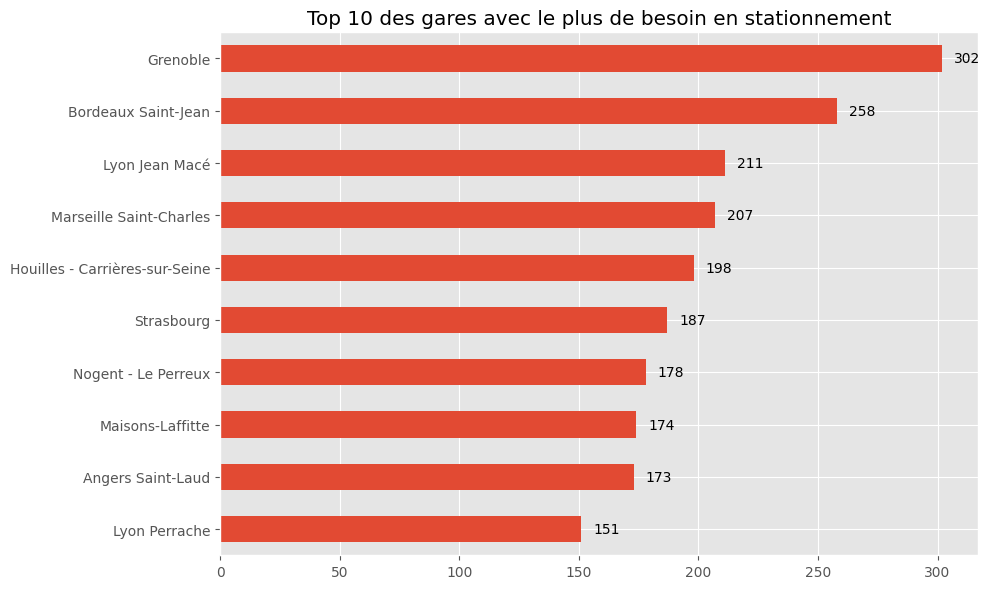

In [26]:
# Afficher les graphiques
ax = besoin_gare_nb.set_index("Nom de la gare").sort_values(
    by=["Nombre de besoin en gare"], 
    ascending=False
).head(10).sort_values(
    by=["Nombre de besoin en gare"], 
    ascending=True
).plot(kind="barh", figsize=(10, 6))
plt.title("Top 10 des gares avec le plus de besoin en stationnement")
plt.legend().remove()
plt.ylabel("")

# Afficher les chiffres
for i in ax.patches:
    ax.text(i.get_width() + 5,
            i.get_y() + i.get_height()/2,
            int(i.get_width()),
            va='center')

plt.tight_layout()
plt.show()


## 4 - Conclusion

Nos analyses révèlent un contraste marqué : même si la proximité d’une gare décuple la probabilité qu’un besoin de stationnement vélo soit signalé (OR ≈ 6,8 ; p ≈ 0), seuls 6,5 % des quelque 295 000 points recensés se trouvent à moins de 100 m des quais. Autrement dit, la gare est un hotspot indéniable, mais loin de concentrer la majorité des demandes ; plus de 93 % des besoins émergent ailleurs sur les trajets quotidiens.

-- END --